reference: https://colab.research.google.com/drive/11_Aw-ZkjjUQ8lZREscFYTyig2UaANS4s?usp=sharing

## 事前準備

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# work spaceにコピー
%%bash

mkdir /content/data
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/train_resize_512.zip /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/add_resize_512.zip /content/data/

cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_train.csv /content/data/
cp /content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/df_add.csv /content/data/

unzip /content/data/train_resize_512.zip -d "/content/data/"
unzip /content/data/add_resize_512.zip -d "/content/data/"

Archive:  /content/data/train_resize_512.zip
   creating: /content/data/train_resize_512/
  inflating: /content/data/train_resize_512/cf7dee34.jpg  
  inflating: /content/data/train_resize_512/4ae939e7.jpg  
  inflating: /content/data/train_resize_512/92bb5890.jpg  
  inflating: /content/data/train_resize_512/ca35d666.jpg  
  inflating: /content/data/train_resize_512/b8d07ead.jpg  
  inflating: /content/data/train_resize_512/399bd91a.jpg  
  inflating: /content/data/train_resize_512/c260c3bb.jpg  
  inflating: /content/data/train_resize_512/7d98f35f.jpg  
  inflating: /content/data/train_resize_512/747edaa6.jpg  
  inflating: /content/data/train_resize_512/204d81c4.jpg  
  inflating: /content/data/train_resize_512/feb03e37.jpg  
  inflating: /content/data/train_resize_512/e993b985.jpg  
  inflating: /content/data/train_resize_512/e1deda4c.jpg  
  inflating: /content/data/train_resize_512/8f496fee.jpg  
  inflating: /content/data/train_resize_512/7addaafe.jpg  
  inflating: /content/dat

In [3]:
# ライブラリインポート
import ast, torch, shutil, yaml, os, cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from glob import glob
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm
from IPython.display import Image, clear_output 
from pathlib import Path

In [4]:
# path
DATA_ROOT = "/content/data/"

TRAIN_PATH = "/content/data/train_resize_512/"
ADD_PATH = "/content/data/add_resize_512/"

In [5]:
# データフレーム
# path列は画像リサイズ時に使用したものであり更新が必要
df_train = pd.read_csv(DATA_ROOT + "df_train.csv")
df_add = pd.read_csv(DATA_ROOT + "df_add.csv")


# Xmin_Ymin_Xmax_Ymaxはread_csvするとstr型なので、リストで扱えるように変換
df_train["Xmin_Ymin_Xmax_Ymax"] = [ast.literal_eval(d) for d in df_train["Xmin_Ymin_Xmax_Ymax"]]
df_train["resized_box"] = [ast.literal_eval(d) for d in df_train["resized_box"]]

df_add["resized_box"] = [ast.literal_eval(d) for d in df_add["resized_box"]]


# trainのpath更新
df_train = df_train.drop('path', axis=1)

paths = glob(TRAIN_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_train = pd.merge(df_train, df_path, on='filename')


# addのpath更新
df_add = df_add.drop('path', axis=1)
paths = glob(ADD_PATH + '*.jpg')
df_path = pd.DataFrame({'path': paths})
df_path["filename"] = df_path["path"].apply(lambda x: x.split("/")[-1])

df_add = pd.merge(df_add, df_path, on='filename')


# trainとaddを結合
df_train = df_train[["filename", "class", "resized_box", "path"]]
df_add = df_add[["filename", "class", "resized_box", "path"]]

df_train = pd.concat([df_train, df_add]).reset_index().drop('index', axis=1)

##EDA

In [6]:
df_train["class"].value_counts()/len(df_train)*100
df_train["class"].value_counts()

USB_Micro_B         934
USB_Type_C          599
Lightning           501
USB_Type_A          416
USB_Mini            278
RJ_45               189
HDMI                175
Lightning_T         169
Mini_DisplayPort    148
VGA                 127
USB_Type_B          126
DisplayPort         114
USB_Micro_B_3.1      94
Dock                 81
USB_Micro_B_W        68
Name: class, dtype: int64

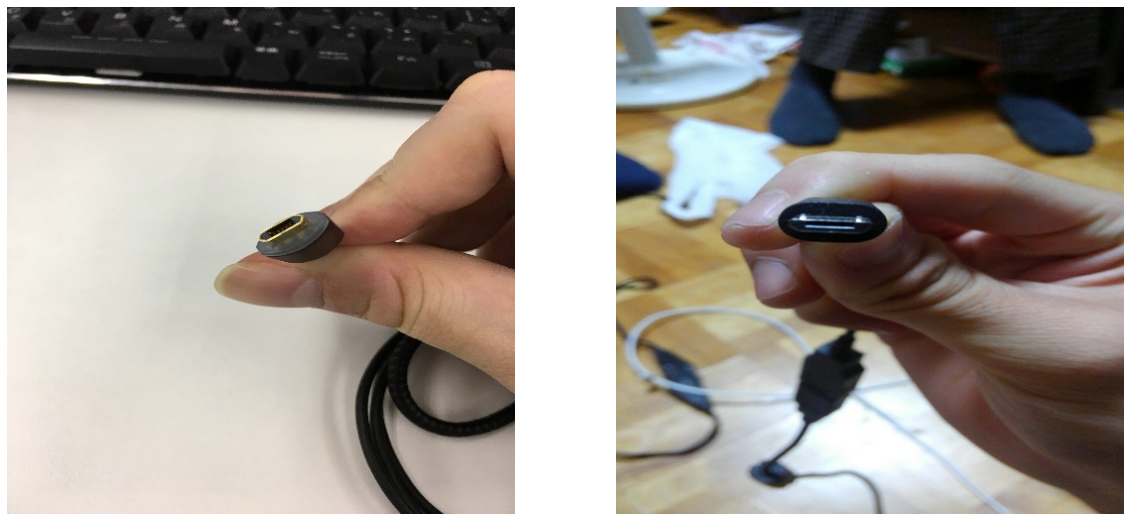

In [8]:
# USB_Micro_B_WとUSB_Micro_B比較
import cv2
import numpy as np
import matplotlib.pyplot as plt

i = np.random.randint(len(df_train[df_train["class"] == 'USB_Micro_B_W']))
j = np.random.randint(len(df_train[df_train["class"] == 'USB_Micro_B']))

tmp = df_train[df_train["class"] == 'USB_Micro_B_W'].iloc[i]
path = tmp['path']
box = tmp['resized_box']
BW = cv2.imread(path)
BW = cv2.cvtColor(BW, cv2.COLOR_BGR2RGB)


tmp = df_train[df_train["class"] == 'USB_Micro_B'].iloc[j]
path = tmp['path']
box = tmp['resized_box']
B = cv2.imread(path)
B = cv2.cvtColor(B, cv2.COLOR_BGR2RGB)



fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(BW)

ax2 = fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(B)

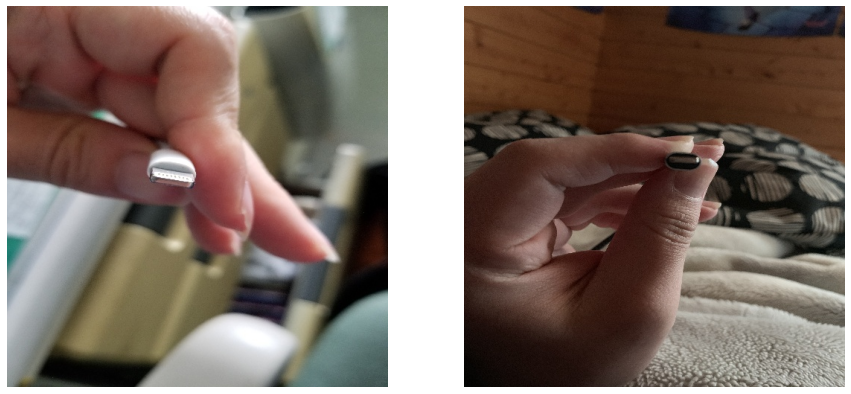

In [9]:
# Lightning_TとLightning比較
import cv2
import numpy as np
import matplotlib.pyplot as plt

i = np.random.randint(len(df_train[df_train["class"] == 'Lightning_T']))
j = np.random.randint(len(df_train[df_train["class"] == 'Lightning']))

tmp = df_train[df_train["class"] == 'Lightning_T'].iloc[i]
path = tmp['path']
box = tmp['resized_box']
BW = cv2.imread(path)
BW = cv2.cvtColor(BW, cv2.COLOR_BGR2RGB)


tmp = df_train[df_train["class"] == 'Lightning'].iloc[j]
path = tmp['path']
box = tmp['resized_box']
B = cv2.imread(path)
B = cv2.cvtColor(B, cv2.COLOR_BGR2RGB)



fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(BW)

ax2 = fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(B)

## 180度回転画像追加

In [10]:
resize = 512

flag = (df_train['class'] == "USB_Micro_B_W") | (df_train['class'] == 'Lightning_T')
tmp = df_train[flag].copy()


for i in tqdm(range(len(tmp))):
    # 回転画像保存
    name = tmp.iloc[i]["filename"]
    name = name[:-4]

    path = tmp.iloc[i]["path"]

    img = cv2.imread(path)
    img_r = cv2.rotate(img, cv2.ROTATE_180)

    name = f'/content/rot/{name}_rot180.jpg'
    Path(name).parent.mkdir(exist_ok=True, parents=True)
    cv2.imwrite(name, img_r)

    # box変換
    box = tmp.iloc[i]['resized_box'] 
    tmp.iloc[i]['resized_box'] = [resize-box[2], resize-box[3], resize-box[0], resize-box[1]]

tmp['filename'] = tmp['filename'].str.replace('.jpg', '_rot180.jpg')
tmp

  0%|          | 0/237 [00:00<?, ?it/s]

,filename,class,resized_box,path
48,3bc098c1_rot180.jpg,Lightning_T,"[196, 283, 340, 390]",/content/data/train_resize_512/3bc098c1.jpg
50,609c2424_rot180.jpg,USB_Micro_B_W,"[181, 276, 323, 363]",/content/data/train_resize_512/609c2424.jpg
75,007d45c8_rot180.jpg,Lightning_T,"[216, 225, 328, 310]",/content/data/train_resize_512/007d45c8.jpg
93,f6fea627_rot180.jpg,Lightning_T,"[200, 220, 321, 264]",/content/data/train_resize_512/f6fea627.jpg
103,fc70db0a_rot180.jpg,Lightning_T,"[181, 191, 262, 254]",/content/data/train_resize_512/fc70db0a.jpg
...,...,...,...,...
3987,8698df0e_rot180.jpg,USB_Micro_B_W,"[133, 163, 235, 239]",/content/data/add_resize_512/8698df0e.jpg
3989,091ebb75_rot180.jpg,USB_Micro_B_W,"[192, 226, 263, 252]",/content/data/add_resize_512/091ebb75.jpg
3999,4091f2c5_rot180.jpg,USB_Micro_B_W,"[220, 282, 308, 332]",/content/data/add_resize_512/4091f2c5.jpg
4001,891b18b7_rot180.jpg,USB_Micro_B_W,"[184, 202, 278, 238]",/content/data/add_resize_512/891b18b7.jpg


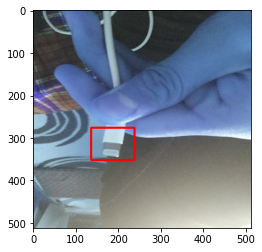

In [11]:
# 確認
path = '/content/rot/609c2424_rot180.jpg'

i = np.random.randint(len(tmp))

box = tmp['resized_box'].iloc[i]
path = "/content/rot/" + tmp['filename'].iloc[i]


img = cv2.imread(path)

red = (255, 0, 0)
cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), red, 3)
plt.imshow(img)

In [12]:
# zip化
!zip -r rot.zip rot

  adding: rot/ (stored 0%)
  adding: rot/1070a982_rot180.jpg (deflated 0%)
  adding: rot/fc72c98a_rot180.jpg (deflated 0%)
  adding: rot/d29d5370_rot180.jpg (deflated 0%)
  adding: rot/a985bb36_rot180.jpg (deflated 1%)
  adding: rot/f6903a12_rot180.jpg (deflated 0%)
  adding: rot/e1b9005b_rot180.jpg (deflated 1%)
  adding: rot/f1ee529e_rot180.jpg (deflated 0%)
  adding: rot/e5481aa7_rot180.jpg (deflated 1%)
  adding: rot/c6d34483_rot180.jpg (deflated 0%)
  adding: rot/fb1548ce_rot180.jpg (deflated 0%)
  adding: rot/bb3d93da_rot180.jpg (deflated 1%)
  adding: rot/bf0a60ee_rot180.jpg (deflated 0%)
  adding: rot/7ac25d5d_rot180.jpg (deflated 1%)
  adding: rot/b74b161d_rot180.jpg (deflated 1%)
  adding: rot/1de4842b_rot180.jpg (deflated 1%)
  adding: rot/509694b0_rot180.jpg (deflated 1%)
  adding: rot/172e1676_rot180.jpg (deflated 1%)
  adding: rot/6aea7c4f_rot180.jpg (deflated 0%)
  adding: rot/56a3a46a_rot180.jpg (deflated 0%)
  adding: rot/24eb6043_rot180.jpg (deflated 0%)
  adding: rot

In [13]:
shutil.copy(f'/content/rot.zip', '/content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets')

'/content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/rot.zip'

In [14]:
tmp.to_csv("/content/drive/MyDrive/project/Nishika_cable-detection_summary/resize_512_datasets/rot.csv", index=False)